# Historical Flood Data

In [1]:
import pandas as pd
# historical flood data
def clean_flood_data():
    flood_df = pd.read_excel('FloodArchive.xlsx', engine='openpyxl')

    #filter only for United States
    flood_df = flood_df[flood_df['Country'] == 'USA']
    #add a zip code based on the long and lat

    return flood_df

flood_df = clean_flood_data()

In [2]:
print(f'USA number of flood incidents: {len(flood_df)}')
print(flood_df.head())
#save as csv
flood_df.to_csv('united_states_floods.csv', index=False)


USA number of flood incidents: 477
    ID GlideNumber Country OtherCountry      long      lat       Area  \
8    9           0     USA            0  -85.1742  40.6691  210527.96   
10  11           0     USA            0  -89.5537  40.6814   26266.14   
11  12           0     USA            0 -108.0930  35.3824   26527.13   
12  13           0     USA            0  -96.7845  29.6044  141508.00   
13  14           0     USA            0  -83.5377  42.0122   16883.54   

        Began      Ended Validation  Dead  Displaced          MainCause  \
8  1985-02-22 1985-03-01       News     7       2250  Rain and snowmelt   
10 1985-03-03 1985-03-08       News     4       2400  Rain and snowmelt   
11 1985-03-13 1985-03-14       News     0         80  Rain and snowmelt   
12 1985-03-14 1985-03-15       News     0          0         Heavy rain   
13 1985-03-30 1985-03-31       News     0        300         Heavy rain   

    Severity  
8        2.0  
10       2.0  
11       1.0  
12       1.0  


In [3]:
# !pip install folium
import folium
import math

#visual representation of FLOOD DATA
map_usa = folium.Map(location=[39.8283, -98.5795], zoom_start=5)
severity_colors = {
    1.0: "yellow", #large flood events: 1-2 decades-long reported interval since the last similar event
    1.5: "orange", #very large events: greater than 2 decades but less than 100 year estimated recurrence interval
    2.0: "red" #Extreme events: with an estimated recurrence interval greater than 100 years.
}

# Add a marker for each flood occurrence
for index, row in flood_df.iterrows():
    # Add a circle marker at each flood location (lat, long)
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        popup=f"ID: {row['ID']} | Severity: {row['Severity']} | Displaced: {row['Displaced']} | Date: {row['Began']}",
        color=severity_colors[row['Severity']] ,
        fill=True,
        fill_opacity=0.6
    ).add_to(map_usa)

# Save map to HTML file
map_usa.save('flood_map.html')


In [4]:
# !pip install sqlalchemy_mate==2.0.0.0

#add zipcode column to flood data
from uszipcode import SearchEngine

search = SearchEngine()

def get_zipcode(lat, lon):
    result = search.by_coordinates(lat, lon)
    if result:
        return result[0].zipcode
    return None

# Apply the get_zipcode function to each row and create a new column 'zipcode'
flood_df['zipcode'] = flood_df.apply(lambda row: get_zipcode(row['lat'], row['long']), axis=1)


/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
#save as csv
pd.set_option('display.max_columns', None)
print(flood_df.head())
flood_df.to_csv('united_states_floods.csv', index=False)

    ID GlideNumber Country OtherCountry      long      lat       Area  \
8    9           0     USA            0  -85.1742  40.6691  210527.96   
10  11           0     USA            0  -89.5537  40.6814   26266.14   
11  12           0     USA            0 -108.0930  35.3824   26527.13   
12  13           0     USA            0  -96.7845  29.6044  141508.00   
13  14           0     USA            0  -83.5377  42.0122   16883.54   

        Began      Ended Validation  Dead  Displaced          MainCause  \
8  1985-02-22 1985-03-01       News     7       2250  Rain and snowmelt   
10 1985-03-03 1985-03-08       News     4       2400  Rain and snowmelt   
11 1985-03-13 1985-03-14       News     0         80  Rain and snowmelt   
12 1985-03-14 1985-03-15       News     0          0         Heavy rain   
13 1985-03-30 1985-03-31       News     0        300         Heavy rain   

    Severity zipcode  
8        2.0   46781  
10       2.0   61611  
11       1.0   87045  
12       1.0   789

# Historical Housing Data

In [6]:
valid_zipcodes = flood_df[~flood_df['zipcode'].isna()]['zipcode'].unique()
def clean_housing_data():
    df = pd.read_csv('hpi_at_bdl_zip5.csv', dtype={'Five-Digit ZIP Code': str})
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    #zipcodes from flood data
    df = df[df['Five-Digit ZIP Code'].isin(valid_zipcodes)]
    return df

df_housing = clean_housing_data()

In [7]:
print(df_housing.head(10))
#save as csv
df_housing.to_csv('united_states_housing.csv', index=False)


     Five-Digit ZIP Code  Year  Annual Change (%)     HPI  HPI with 1990 base  \
2401               01253  2001                NaN  100.00                 NaN   
2402               01253  2002               9.38  109.38                 NaN   
2403               01253  2003               2.17  111.75                 NaN   
2404               01253  2004              21.80  136.12                 NaN   
2405               01253  2005               8.09  147.13                 NaN   
2406               01253  2006              12.92  166.14                 NaN   
2407               01253  2007              -2.73  161.60                 NaN   
2408               01253  2008              -1.61  159.00                 NaN   
2409               01253  2009              -2.66  154.77                 NaN   
2410               01253  2010               0.33  155.28                 NaN   

      HPI with 2000 base  
2401                 NaN  
2402                 NaN  
2403                 NaN  


# Random Forest Regressor

## clean & merge data

In [8]:
#code for predicing HPI based on flood data
#load data
import pandas as pd
flood_data = pd.read_csv('united_states_floods.csv', dtype={'zipcode': str})
housing_data = pd.read_csv('united_states_housing.csv', dtype={'Five-Digit ZIP Code': str})
print(flood_data.head(5))


   ID GlideNumber Country OtherCountry      long      lat       Area  \
0   9           0     USA            0  -85.1742  40.6691  210527.96   
1  11           0     USA            0  -89.5537  40.6814   26266.14   
2  12           0     USA            0 -108.0930  35.3824   26527.13   
3  13           0     USA            0  -96.7845  29.6044  141508.00   
4  14           0     USA            0  -83.5377  42.0122   16883.54   

        Began       Ended Validation  Dead  Displaced          MainCause  \
0  1985-02-22  1985-03-01       News     7       2250  Rain and snowmelt   
1  1985-03-03  1985-03-08       News     4       2400  Rain and snowmelt   
2  1985-03-13  1985-03-14       News     0         80  Rain and snowmelt   
3  1985-03-14  1985-03-15       News     0          0         Heavy rain   
4  1985-03-30  1985-03-31       News     0        300         Heavy rain   

   Severity zipcode  
0       2.0   46781  
1       2.0   61611  
2       1.0   87045  
3       1.0   78962  


In [9]:
print(housing_data.head(5))

  Five-Digit ZIP Code  Year  Annual Change (%)     HPI  HPI with 1990 base  \
0               01253  2001                NaN  100.00                 NaN   
1               01253  2002               9.38  109.38                 NaN   
2               01253  2003               2.17  111.75                 NaN   
3               01253  2004              21.80  136.12                 NaN   
4               01253  2005               8.09  147.13                 NaN   

   HPI with 2000 base  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  


In [10]:
#SUMMARIZE FLOOD EVENTS
# For each zip code, get a summary of the floods that occurred up to and including that year.
# calculate duration(in days)
flood_data['Began'] = pd.to_datetime(flood_data['Began'])
flood_data['Ended'] = pd.to_datetime(flood_data['Ended'])
flood_data.loc[:, 'Duration'] = (flood_data['Ended'] - flood_data['Began']).dt.days
flood_data['Year'] = flood_data['Began'].dt.year


# # aggregate flood data by zip code and year
flood_summary = flood_data.groupby(['zipcode', 'Year']).agg(
    flood_count=('Severity', 'count'),
    max_severity=('Severity', lambda x: x.max()),
    median_dead=('Dead', 'median'),
    median_displaced=('Displaced', 'median'),
    median_duration=('Duration', 'median'),
    median_area = ('Area', 'median')
).reset_index()

flood_summary



,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area
0,00641,1985,1,1.0,2.0,4500.0,1.0,1423.92
1,00664,1985,1,1.0,99.0,6200.0,2.0,7219.80
2,00698,2001,1,1.0,2.0,0.0,1.0,245.95
3,01031,1996,1,2.0,5.0,700.0,4.0,67013.98
4,01031,2007,1,1.0,9.0,0.0,6.0,109079.09
...,...,...,...,...,...,...,...,...
450,99705,1991,1,1.0,2.0,800.0,4.0,22130.06
451,99705,2003,1,1.0,0.0,0.0,4.0,1681.67
452,99709,2003,1,1.0,0.0,0.0,5.0,6718.98
453,99743,2003,1,1.0,0.0,20.0,4.0,13111.55


In [11]:
housing_data.rename(columns={'Five-Digit ZIP Code': 'zipcode'}, inplace=True)

# Merge flood summary with housing price index data based on 'zipcode' and 'Year'
merged_data = pd.merge(flood_summary, housing_data, on=['zipcode', 'Year'], how='left')

# Display the first few rows of the merged data
merged_data

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,00641,1985,1,1.0,2.0,4500.0,1.0,1423.92,NaN,NaN,NaN,NaN
1,00664,1985,1,1.0,99.0,6200.0,2.0,7219.80,NaN,NaN,NaN,NaN
2,00698,2001,1,1.0,2.0,0.0,1.0,245.95,NaN,NaN,NaN,NaN
3,01031,1996,1,2.0,5.0,700.0,4.0,67013.98,NaN,NaN,NaN,NaN
4,01031,2007,1,1.0,9.0,0.0,6.0,109079.09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
450,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,20.76,72.44,120.76,69.72
451,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,4.43,113.15,188.63,108.90
452,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,2.88,246.91,162.72,110.30
453,99743,2003,1,1.0,0.0,20.0,4.0,13111.55,NaN,NaN,NaN,NaN


In [12]:
#drop unmatched rows
#NOTE ROWS DROPPED PRETTY SIGNIFICANTLY
merged_data = merged_data.dropna(subset=['HPI'])
merged_data.to_csv('merged_housing_flood_data.csv', index=False)
merged_data

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
6,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,6.20,468.17,230.13,164.19
8,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,0.50,122.27,NaN,NaN
12,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,3.83,314.67,214.37,164.46
18,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,5.12,105.12,NaN,NaN
19,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
448,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,1.72,116.20,NaN,107.77
450,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,20.76,72.44,120.76,69.72
451,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,4.43,113.15,188.63,108.90
452,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,2.88,246.91,162.72,110.30


## Run Regressor Model

#### initial, no optimization

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

#Use RandomForestRegressor to predict HPI based on floods

X = merged_data[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = merged_data['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# evaluate the model performance
print("Random Forest Regressor: Predicting HPI(no past history, just current year):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

print(f"Predictions: {y_pred[:10]}")
print(f"Actual: {y_test[:10].values}")

Random Forest Regressor: Predicting HPI(no past history, just current year):
R² score: 0.038
Mean Absolute Error (MAE): 129.119
Relative Error: 49.68%
Predictions: [163.2591 293.4683 211.43   176.737  162.957  169.1713 186.4936 290.3237
 377.8678 205.2127]
Actual: [ 147.38 2220.62  236.46  186.07  174.23  113.15  179.46  733.52  127.62
  352.21]


In [19]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 132.51, Baseline R²: -0.02


#### Improved Random Forest Regressor(w/ hyperparameter tuning)



In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

X = merged_data[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = merged_data['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf_model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train_scaled, y_train)
print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")

best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)
y_pred = best_rf_model.predict(X_test_scaled)

# evaluate the model's performance
print("Random Forest Regressor: Predicting HPI(no past history, just current year):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

print(f"Predictions: {y_pred[:10]}")  # First 10 predicted values
print(f"Actual: {y_test[:10].values}")  # First 10 actual values

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; tot

In [21]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 132.51, Baseline R²: -0.02


### Random Forest Regressor w/ past memory(10 years prior)

In [22]:
flood_data = flood_data.dropna(subset=['zipcode', 'Year'])

In [23]:
# Create the 3-area zipcode column (first 3 digits of zipcode)
flood_summary['zipcode_3area'] = flood_summary['zipcode'].astype(str).str[:3]
flood_summary = flood_summary.sort_values(by=['zipcode_3area', 'Year'])

flood_summary_10_years = flood_summary.copy()

# Rolling average for each feature, grouped by the 3-area zipcode
flood_summary_10_years['flood_count_total_10'] = flood_summary.groupby('zipcode_3area')['flood_count'].transform(lambda x: x.rolling(window=10, min_periods=1).sum())
flood_summary_10_years['max_severity_avg_10'] = flood_summary.groupby('zipcode_3area')['max_severity'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
flood_summary_10_years['median_dead_avg_10'] = flood_summary.groupby('zipcode_3area')['median_dead'].transform(lambda x: x.rolling(window=10, min_periods=1).median())
flood_summary_10_years['median_displaced_avg_10'] = flood_summary.groupby('zipcode_3area')['median_displaced'].transform(lambda x: x.rolling(window=10, min_periods=1).median())
flood_summary_10_years['median_duration_avg_10'] = flood_summary.groupby('zipcode_3area')['median_duration'].transform(lambda x: x.rolling(window=10, min_periods=1).median())
flood_summary_10_years['median_area_avg_10'] = flood_summary.groupby('zipcode_3area')['median_area'].transform(lambda x: x.rolling(window=10, min_periods=1).median())


flood_summary_10_years.head(10)


,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10
0,00641,1985,1,1.0,2.0,4500.0,1.0,1423.92,006,1.0,1.0,2.0,4500.0,1.0,1423.920
1,00664,1985,1,1.0,99.0,6200.0,2.0,7219.80,006,2.0,1.0,50.5,5350.0,1.5,4321.860
2,00698,2001,1,1.0,2.0,0.0,1.0,245.95,006,3.0,1.0,2.0,4500.0,1.0,1423.920
3,01031,1996,1,2.0,5.0,700.0,4.0,67013.98,010,1.0,2.0,5.0,700.0,4.0,67013.980
4,01031,2007,1,1.0,9.0,0.0,6.0,109079.09,010,2.0,1.5,7.0,350.0,5.0,88046.535
5,01253,1998,1,2.0,0.0,0.0,2.0,1697.01,012,1.0,2.0,0.0,0.0,2.0,1697.010
6,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,017,1.0,1.5,0.0,0.0,2.0,5095.450
7,03262,1990,1,1.0,0.0,400.0,4.0,20288.60,032,1.0,1.0,0.0,400.0,4.0,20288.600
8,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,034,1.0,2.0,11.0,3000.0,9.0,38291.770
10,03585,1998,1,2.0,21.0,11000.0,7.0,18116.79,035,1.0,2.0,21.0,11000.0,7.0,18116.790


In [24]:
merged_data = pd.merge(flood_summary_10_years, housing_data, on=['zipcode', 'Year'], how='left')
merged_data = merged_data.dropna(subset=['HPI'])

#save data
merged_data.to_csv('merged_housing_flood_data_avg_10_years.csv', index=False)
merged_data

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
6,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,017,1.0,1.5,0.0,0.0,2.0,5095.450,6.20,468.17,230.13,164.19
8,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,034,1.0,2.0,11.0,3000.0,9.0,38291.770,0.50,122.27,NaN,NaN
12,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,039,1.0,2.0,1.0,2500.0,11.0,42910.990,3.83,314.67,214.37,164.46
18,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,056,2.0,1.5,0.0,0.0,2.0,6344.380,5.12,105.12,NaN,NaN
19,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,060,1.0,1.0,0.0,250.0,1.0,4609.140,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,996,2.0,2.0,0.0,150.0,16.0,32151.255,1.72,116.20,NaN,107.77
449,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,997,1.0,1.0,2.0,800.0,4.0,22130.060,20.76,72.44,120.76,69.72
451,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,997,3.0,1.0,0.0,0.0,4.0,1681.670,4.43,113.15,188.63,108.90
452,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,997,4.0,1.0,0.0,0.0,4.0,4200.325,2.88,246.91,162.72,110.30


In [25]:
X = merged_data[['flood_count', 'max_severity', 'median_dead', 'median_displaced',
                 'median_duration', 'median_area',
                 'flood_count_total_10', 'max_severity_avg_10',
                 'median_dead_avg_10', 'median_displaced_avg_10',
                 'median_duration_avg_10', 'median_area_avg_10']]

y = merged_data['HPI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 15, min_samples_leaf= 1, max_depth= 40, bootstrap= True)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# evaluate the model's performance
print("Random Forest Regressor: Predicting HPI(w/ past history, prior 10 year flood averages):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

print(f"Predictions: {y_pred[:10]}")  # First 10 predicted values
print(f"Actual: {y_test[:10].values}")  # First 10 actual values

Random Forest Regressor: Predicting HPI(w/ past history, prior 10 year flood averages):
R² score: 0.120
Mean Absolute Error (MAE): 131.837
Relative Error: 49.42%
Predictions: [172.68589823 403.84658006 238.97032686 287.32606985 228.25698646
 208.59917858 176.80587846 239.45788787 316.13303172 264.96035978]
Actual: [ 147.38 2220.62  236.46  186.07  128.93  113.15  179.46  733.52  127.62
  352.21]


In [26]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 139.57, Baseline R²: -0.03


# Synthesizing Data

## Current Year Synthesized

In [27]:
import pandas as pd
original_data = pd.read_csv('merged_housing_flood_data.csv', dtype={'zipcode': str})
original_data

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,2.88,246.91,162.72,110.30


In [28]:
from sklearn.mixture import GaussianMixture

from sklearn.metrics import pairwise_distances_argmin_min

numeric_columns = ['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area', 'HPI']
data_for_gmm = original_data[numeric_columns].dropna()

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data_for_gmm)

synthetic_data = gmm.sample(n_samples=1000)
synthetic_df = pd.DataFrame(synthetic_data[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df[numeric_columns], original_data[numeric_columns])
synthetic_df['zipcode'] = original_data['zipcode'].iloc[distances[0]].values
synthetic_df['Year'] = original_data['Year'].iloc[distances[0]].values

expanded_data = pd.concat([original_data, synthetic_df], axis=0)
expanded_data = expanded_data.reset_index(drop=True)


expanded_data


,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
1207,28305,2018,1.000030,2.000005,12.001832,1.500000e+06,17.000324,95203.220782,NaN,262.809287,NaN,NaN
1208,28305,2018,0.999888,1.999611,11.999999,1.500000e+06,17.001987,95203.220668,NaN,262.809880,NaN,NaN
1209,28305,2018,0.999147,2.000491,12.002010,1.500000e+06,17.000388,95203.218289,NaN,262.809289,NaN,NaN
1210,28305,2018,0.999589,2.000202,11.998635,1.500000e+06,16.999873,95203.221286,NaN,262.809169,NaN,NaN


In [29]:
X = expanded_data[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = expanded_data['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 15, min_samples_leaf= 1, max_depth= 40, bootstrap= True)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# evaluate the model performance
print("Random Forest Regressor: Predicting HPI(no past history, synthetic data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')



print(f"Predictions: {y_pred[:10]}")
print(f"Actual: {y_test[:10].values}")



Random Forest Regressor: Predicting HPI(no past history, synthetic data):
R² score: 0.528
Mean Absolute Error (MAE): 89.127
Relative Error: 39.39%
Predictions: [225.35178891 168.5366116  283.86421767 110.10521764 186.11645664
 188.91167764 201.05653257 198.09241354 196.66931099 214.32757702]
Actual: [204.74036562 142.78707016 162.32       225.39176753 139.71
 208.92185444 230.89138635 246.91       195.38810304 119.61606379]


In [30]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 111.92, Baseline R²: -0.00


## Prior Year Averages Synthesized

In [31]:
import numpy as np
original_data_10 = pd.read_csv('merged_housing_flood_data_avg_10_years.csv', dtype={'zipcode': str, 'zipcode_3area':str})
original_data_10

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,017,1.0,1.5,0.0,0.0,2.0,5095.450,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,034,1.0,2.0,11.0,3000.0,9.0,38291.770,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,039,1.0,2.0,1.0,2500.0,11.0,42910.990,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,056,2.0,1.5,0.0,0.0,2.0,6344.380,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,060,1.0,1.0,0.0,250.0,1.0,4609.140,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,996,2.0,2.0,0.0,150.0,16.0,32151.255,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,997,1.0,1.0,2.0,800.0,4.0,22130.060,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,997,3.0,1.0,0.0,0.0,4.0,1681.670,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,997,4.0,1.0,0.0,0.0,4.0,4200.325,2.88,246.91,162.72,110.30


In [32]:
original_data_10.columns

Index(['zipcode', 'Year', 'flood_count', 'max_severity', 'median_dead',
       'median_displaced', 'median_duration', 'median_area', 'zipcode_3area',
       'flood_count_total_10', 'max_severity_avg_10', 'median_dead_avg_10',
       'median_displaced_avg_10', 'median_duration_avg_10',
       'median_area_avg_10', 'Annual Change (%)', 'HPI', 'HPI with 1990 base',
       'HPI with 2000 base'],
      dtype='object')

In [33]:
from sklearn.mixture import GaussianMixture

from sklearn.metrics import pairwise_distances_argmin_min

numeric_columns = ['flood_count', 'max_severity', 'median_dead',
       'median_displaced', 'median_duration', 'median_area',
       'flood_count_total_10', 'max_severity_avg_10', 'median_dead_avg_10',
       'median_displaced_avg_10', 'median_duration_avg_10',
       'median_area_avg_10', 'HPI']
data_for_gmm_10 = original_data_10[numeric_columns].dropna()

gmm_10 = GaussianMixture(n_components=3, random_state=42)
gmm_10.fit(data_for_gmm_10)

synthetic_data_10 = gmm_10.sample(n_samples=1000)
synthetic_df_10 = pd.DataFrame(synthetic_data_10[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df_10[numeric_columns], original_data_10[numeric_columns])
synthetic_df_10['zipcode'] = original_data_10['zipcode'].iloc[distances[0]].values
synthetic_df_10['Year'] = original_data_10['Year'].iloc[distances[0]].values

synthetic_df_10['zipcode_3area'] = synthetic_df_10['zipcode'].astype(str).str[:3]


expanded_data_10 = pd.concat([original_data_10, synthetic_df_10], axis=0)
expanded_data_10 = expanded_data_10.reset_index(drop=True)



expanded_data_10

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/mixture/_base.py:436: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,017,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,034,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,039,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,056,2.000000,1.500000,0.000000,0.000000e+00,2.000000,6344.380000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,060,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,28305,2018,0.998809,1.999742,12.002096,1.500000e+06,16.999892,95203.219739,283,0.999854,1.998309,11.999544,1.500000e+06,16.999999,95203.221242,NaN,262.809324,NaN,NaN
1208,28305,2018,0.999712,2.000070,12.000808,1.500000e+06,16.999735,95203.219062,283,0.997977,1.999285,11.999537,1.500000e+06,16.999085,95203.217877,NaN,262.808980,NaN,NaN
1209,28305,2018,0.998054,2.000009,11.999496,1.500000e+06,17.000912,95203.221092,283,0.998727,1.999434,11.999565,1.500000e+06,17.001292,95203.220713,NaN,262.808471,NaN,NaN
1210,28305,2018,0.999849,2.000880,12.001431,1.500000e+06,17.001174,95203.217718,283,1.001001,2.000009,12.001380,1.500000e+06,16.998859,95203.220002,NaN,262.807889,NaN,NaN


In [34]:
X = expanded_data_10[['flood_count', 'max_severity', 'median_dead', 'median_displaced',
                 'median_duration', 'median_area',
                 'flood_count_total_10', 'max_severity_avg_10',
                 'median_dead_avg_10', 'median_displaced_avg_10',
                 'median_duration_avg_10', 'median_area_avg_10', 'zipcode_3area']]

y = expanded_data_10['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split= 15, min_samples_leaf= 1, max_depth= 40, bootstrap= True)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# evaluate the model performance
print("Random Forest Regressor: Predicting HPI(w/ past history, prior 10 year flood averages, synthetic data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')



print(f"Predictions: {y_pred[:10]}")
print(f"Actual: {y_test[:10].values}")

Random Forest Regressor: Predicting HPI(w/ past history, prior 10 year flood averages, synthetic data):
R² score: 0.131
Mean Absolute Error (MAE): 116.861
Relative Error: 49.33%
Predictions: [203.10222937 153.57903708 233.02366095 181.7086522  195.64496862
 134.34940317 179.76656492 233.23226699 311.15579074 320.09192525]
Actual: [111.83751463  87.91973092 162.32       320.37251149 139.71
 168.44417393 373.07095555 246.91       263.55377839 117.50263975]


In [35]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 122.00, Baseline R²: -0.00


# TabPFN

### Install package

In [36]:
#https://github.com/PriorLabs/TabPFN?tab=readme-ov-file
!pip install tabpfn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Real Housing-Flood Data

In [37]:
import pandas as pd
import numpy as np
df_real = pd.read_csv('merged_housing_flood_data.csv', dtype={'zipcode': str})
df_real

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,2.88,246.91,162.72,110.30


In [38]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming there is a TabPFNRegressor (if not, a different regressor should be used)
from tabpfn import TabPFNRegressor

X = df_real[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = df_real['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the regressor
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# Predict on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
relative_error = mae / np.mean(y_test) * 100

print("TabPFNRegressor (current year only, real data)")
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print("R² Score:", r2)

print(f'Relative Error: {relative_error:.2f}%')

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/tabpfn/base.py:101: UserWarning: Downloading model to /Users/melinagarza/Library/Caches/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFNRegressor (current year only, real data)
Mean Absolute Error (MAE): 114.974
R² Score: 0.0024922261072236607
Relative Error: 46.99%


In [39]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 113.08, Baseline R²: -0.01


In [40]:
df_real_10_avg = pd.read_csv('merged_housing_flood_data_avg_10_years.csv', dtype={'zipcode': str})
df_real_10_avg

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,17,1.0,1.5,0.0,0.0,2.0,5095.450,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,34,1.0,2.0,11.0,3000.0,9.0,38291.770,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,39,1.0,2.0,1.0,2500.0,11.0,42910.990,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,56,2.0,1.5,0.0,0.0,2.0,6344.380,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,60,1.0,1.0,0.0,250.0,1.0,4609.140,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,996,2.0,2.0,0.0,150.0,16.0,32151.255,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,997,1.0,1.0,2.0,800.0,4.0,22130.060,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,997,3.0,1.0,0.0,0.0,4.0,1681.670,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,997,4.0,1.0,0.0,0.0,4.0,4200.325,2.88,246.91,162.72,110.30


In [41]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming there is a TabPFNRegressor (if not, a different regressor should be used)
from tabpfn import TabPFNRegressor

X = df_real_10_avg[['flood_count', 'max_severity', 'median_dead', 'median_displaced',
                 'median_duration', 'median_area',
                 'flood_count_total_10', 'max_severity_avg_10',
                 'median_dead_avg_10', 'median_displaced_avg_10',
                 'median_duration_avg_10', 'median_area_avg_10']]
y = df_real_10_avg['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the regressor
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# Predict on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
relative_error = mae / np.mean(y_test) * 100

print("TabPFNRegressor (including 10 year prior averages, real data)")
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print("R² Score:", r2)
print(f'Relative Error: {relative_error:.2f}%')

TabPFNRegressor (including 10 year prior averages, real data)
Mean Absolute Error (MAE): 127.143
R² Score: 0.059783845702556015
Relative Error: 51.44%


In [42]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 116.14, Baseline R²: -0.02


## Synthetic Housing-Flood Data

### Current Year Data

In [43]:
from sklearn.mixture import GaussianMixture

from sklearn.metrics import pairwise_distances_argmin_min

numeric_columns = ['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area', 'HPI']
data_for_gmm = df_real[numeric_columns].dropna()

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data_for_gmm)

synthetic_data = gmm.sample(n_samples=800)
synthetic_df = pd.DataFrame(synthetic_data[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df[numeric_columns], df_real[numeric_columns])
synthetic_df['zipcode'] = df_real['zipcode'].iloc[distances[0]].values
synthetic_df['Year'] = df_real['Year'].iloc[distances[0]].values

expanded_data_tabpfn = pd.concat([df_real, synthetic_df], axis=0)
expanded_data_tabpfn = expanded_data_tabpfn.reset_index(drop=True)

expanded_data_tabpfn.to_csv('expanded_data_tabpfn.csv', index=False)

expanded_data_tabpfn

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
1007,28305,2018,1.000234,2.001476,12.001852,1.500000e+06,16.999215,95203.218168,NaN,262.809473,NaN,NaN
1008,28305,2018,0.998840,2.000107,11.999518,1.500000e+06,17.000877,95203.220927,NaN,262.810634,NaN,NaN
1009,28305,2018,1.000618,2.000918,11.999954,1.500000e+06,16.998506,95203.218441,NaN,262.810271,NaN,NaN
1010,28305,2018,0.999143,2.000009,12.000106,1.500000e+06,17.000938,95203.220478,NaN,262.808731,NaN,NaN


In [44]:
from sklearn.model_selection import train_test_split
X = expanded_data_tabpfn[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = expanded_data_tabpfn['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the regressor
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# Predict on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
relative_error = mae / np.mean(y_test) * 100

print("TabPFNRegressor (current year only, synthetic data)")
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print("R² Score:", r2)
print(f'Relative Error: {relative_error:.2f}%')

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


TabPFNRegressor (current year only, synthetic data)
Mean Absolute Error (MAE): 82.009
R² Score: 0.4245781246382261
Relative Error: 35.98%


In [45]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 109.53, Baseline R²: -0.00


In [46]:
#save model
import pickle

# save
with open('tabpfn_regressor_synthetic_current_year.pkl','wb') as f:
    pickle.dump(regressor,f)


### Prior 10 year averages

In [47]:
numeric_columns = ['flood_count', 'max_severity', 'median_dead',
       'median_displaced', 'median_duration', 'median_area',
       'flood_count_total_10', 'max_severity_avg_10', 'median_dead_avg_10',
       'median_displaced_avg_10', 'median_duration_avg_10',
       'median_area_avg_10', 'HPI']
data_for_gmm_10 = df_real_10_avg[numeric_columns].dropna()

gmm_10 = GaussianMixture(n_components=3, random_state=42)
gmm_10.fit(data_for_gmm_10)

synthetic_data_10 = gmm_10.sample(n_samples=800)
synthetic_df_10 = pd.DataFrame(synthetic_data_10[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df_10[numeric_columns], df_real_10_avg[numeric_columns])
synthetic_df_10['zipcode'] = df_real_10_avg['zipcode'].iloc[distances[0]].values
synthetic_df_10['Year'] = df_real_10_avg['Year'].iloc[distances[0]].values
synthetic_df_10['zipcode_3area'] = synthetic_df_10['zipcode'].astype(str).str[:3]

expanded_data_tabpfn_10 = pd.concat([df_real_10_avg, synthetic_df_10], axis=0)
expanded_data_tabpfn_10 = expanded_data_tabpfn_10.reset_index(drop=True)


expanded_data_tabpfn_10

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/mixture/_base.py:436: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,17,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,34,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,39,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,56,2.000000,1.500000,0.000000,0.000000e+00,2.000000,6344.380000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,60,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,28305,2018,0.999982,2.000095,11.999633,1.500000e+06,17.000142,95203.218582,283,0.999398,1.999966,11.999434,1.500000e+06,17.001677,95203.221441,NaN,262.809282,NaN,NaN
1008,28305,2018,0.998687,2.001198,11.999699,1.500000e+06,16.997646,95203.220453,283,1.000230,1.999630,12.000302,1.500000e+06,16.999953,95203.219961,NaN,262.812922,NaN,NaN
1009,28305,2018,1.000997,1.999137,12.000459,1.500000e+06,17.000009,95203.220712,283,0.999094,2.000688,12.000302,1.500000e+06,17.001915,95203.221617,NaN,262.809570,NaN,NaN
1010,28305,2018,0.998749,2.000397,11.998589,1.500000e+06,17.000739,95203.218898,283,0.998222,2.000943,12.001501,1.500000e+06,17.000286,95203.219933,NaN,262.811049,NaN,NaN


In [48]:
X = expanded_data_tabpfn_10[['flood_count', 'max_severity', 'median_dead',
       'median_displaced', 'median_duration', 'median_area',
       'flood_count_total_10', 'max_severity_avg_10', 'median_dead_avg_10',
       'median_displaced_avg_10', 'median_duration_avg_10',
       'median_area_avg_10']]
y = expanded_data_tabpfn_10['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the regressor
regressor = TabPFNRegressor()
regressor.fit(X_train, y_train)

# Predict on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
relative_error = mae / np.mean(y_test) * 100

print("TabPFNRegressor (prior 10 year averages, synthetic data)")
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print("R² Score:", r2)
print(f'Relative Error: {relative_error:.2f}%')

TabPFNRegressor (prior 10 year averages, synthetic data)
Mean Absolute Error (MAE): 114.331
R² Score: 0.1793396500369392
Relative Error: 50.31%


In [49]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 129.05, Baseline R²: -0.00


# Baseline, good reference to see if model is the problem or data

In [50]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")


Baseline MAE: 129.05, Baseline R²: -0.00


# CatBoostRegressor

## Install package


In [51]:
#install package
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 44.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 51.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Real Housing-Flood Data

### Current Year Data

In [52]:
#load data
df_real = pd.read_csv('merged_housing_flood_data.csv', dtype={'zipcode': str})
df_real

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,2.88,246.91,162.72,110.30


In [53]:
#run model
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np


X = df_real[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = df_real['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#early stopping
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_test, y_test)

cat_model = CatBoostRegressor(
     iterations=5000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=100,  # Stop if no improvement on test set
    verbose=100,
    random_seed=42
)


cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
y_pred = cat_model.predict(X_test)

print("CatBoost Regressor (no past history, real data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

0:	learn: 147.5129271	test: 309.6445833	best: 309.6445833 (0)	total: 56.1ms	remaining: 4m 40s
100:	learn: 99.6296133	test: 307.5760534	best: 306.3831901 (82)	total: 79.7ms	remaining: 3.87s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 306.3831901
bestIteration = 82

Shrink model to first 83 iterations.
CatBoost Regressor (no past history, real data):
R² score: 0.004
Mean Absolute Error (MAE): 123.691
Relative Error: 47.59%


In [54]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 132.51, Baseline R²: -0.02


### Prior 10 year averages

In [55]:
#load data
df_real_10_avg = pd.read_csv('merged_housing_flood_data_avg_10_years.csv', dtype={'zipcode': str})
df_real_10_avg

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1,1.5,0.0,0.0,2.0,5095.45,17,1.0,1.5,0.0,0.0,2.0,5095.450,6.20,468.17,230.13,164.19
1,03448,2005,1,2.0,11.0,3000.0,9.0,38291.77,34,1.0,2.0,11.0,3000.0,9.0,38291.770,0.50,122.27,NaN,NaN
2,03903,2006,1,2.0,1.0,2500.0,11.0,42910.99,39,1.0,2.0,1.0,2500.0,11.0,42910.990,3.83,314.67,214.37,164.46
3,05680,2002,1,1.0,0.0,0.0,2.0,11377.32,56,2.0,1.5,0.0,0.0,2.0,6344.380,5.12,105.12,NaN,NaN
4,06023,1992,1,1.0,0.0,250.0,1.0,4609.14,60,1.0,1.0,0.0,250.0,1.0,4609.140,NaN,100.00,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,99669,2002,1,2.0,0.0,0.0,4.0,13912.96,996,2.0,2.0,0.0,150.0,16.0,32151.255,1.72,116.20,NaN,107.77
208,99705,1991,1,1.0,2.0,800.0,4.0,22130.06,997,1.0,1.0,2.0,800.0,4.0,22130.060,20.76,72.44,120.76,69.72
209,99705,2003,1,1.0,0.0,0.0,4.0,1681.67,997,3.0,1.0,0.0,0.0,4.0,1681.670,4.43,113.15,188.63,108.90
210,99709,2003,1,1.0,0.0,0.0,5.0,6718.98,997,4.0,1.0,0.0,0.0,4.0,4200.325,2.88,246.91,162.72,110.30


In [56]:
#run model
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np


X = df_real_10_avg[['flood_count', 'max_severity', 'median_dead', 'median_displaced',
                 'median_duration', 'median_area',
                 'flood_count_total_10', 'max_severity_avg_10',
                 'median_dead_avg_10', 'median_displaced_avg_10',
                 'median_duration_avg_10', 'median_area_avg_10']]
y = df_real_10_avg['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#early stopping
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_test, y_test)

cat_model = CatBoostRegressor(
     iterations=5000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=100,  # Stop if no improvement on test set
    verbose=100,
    random_seed=42
)


cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
y_pred = cat_model.predict(X_test)

print("CatBoost Regressor(prior 10 year averages history, real data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

0:	learn: 140.9963529	test: 318.2072542	best: 318.2072542 (0)	total: 1.24ms	remaining: 6.18s
100:	learn: 77.8630588	test: 297.8741497	best: 297.7853270 (98)	total: 31ms	remaining: 1.5s
200:	learn: 50.9606738	test: 289.6940188	best: 289.5280234 (192)	total: 60.8ms	remaining: 1.45s
300:	learn: 35.4837260	test: 288.5248018	best: 288.1545309 (285)	total: 94.2ms	remaining: 1.47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 288.1545309
bestIteration = 285

Shrink model to first 286 iterations.
CatBoost Regressor(prior 10 year averages history, real data):
R² score: 0.159
Mean Absolute Error (MAE): 131.561
Relative Error: 49.31%


In [57]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 139.57, Baseline R²: -0.03


## Synthetic Housing-Flood Data

### Current Year Data

In [58]:
#load data
from sklearn.mixture import GaussianMixture

from sklearn.metrics import pairwise_distances_argmin_min

numeric_columns = ['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area', 'HPI']
data_for_gmm = df_real[numeric_columns].dropna()

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data_for_gmm)

synthetic_data = gmm.sample(n_samples=800)
synthetic_df = pd.DataFrame(synthetic_data[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df[numeric_columns], df_real[numeric_columns])
synthetic_df['zipcode'] = df_real['zipcode'].iloc[distances[0]].values
synthetic_df['Year'] = df_real['Year'].iloc[distances[0]].values

expanded_data_catboost = pd.concat([df_real, synthetic_df], axis=0)
expanded_data_catboost = expanded_data_catboost.reset_index(drop=True)
expanded_data_catboost.to_csv('expanded_data_catboost.csv', index=False)

expanded_data_catboost

,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...
1007,28305,2018,1.000234,2.001476,12.001852,1.500000e+06,16.999215,95203.218168,NaN,262.809473,NaN,NaN
1008,28305,2018,0.998840,2.000107,11.999518,1.500000e+06,17.000877,95203.220927,NaN,262.810634,NaN,NaN
1009,28305,2018,1.000618,2.000918,11.999954,1.500000e+06,16.998506,95203.218441,NaN,262.810271,NaN,NaN
1010,28305,2018,0.999143,2.000009,12.000106,1.500000e+06,17.000938,95203.220478,NaN,262.808731,NaN,NaN


In [59]:
#run model
from catboost import CatBoostRegressor, Pool
X = expanded_data_catboost[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = expanded_data_catboost['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#early stopping
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_test, y_test)

cat_model = CatBoostRegressor(
     iterations=5000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=100,  # Stop if no improvement on test set
    verbose=100,
    random_seed=42
)

cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
y_pred = cat_model.predict(X_test)

print("CatBoost Regressor (no past history, synthetic data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

0:	learn: 208.7318196	test: 185.4816892	best: 185.4816892 (0)	total: 997us	remaining: 4.98s
100:	learn: 130.1570357	test: 125.1192446	best: 125.1192446 (100)	total: 56ms	remaining: 2.71s
200:	learn: 105.3979580	test: 127.3631381	best: 124.9028464 (109)	total: 109ms	remaining: 2.59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 124.9028464
bestIteration = 109

Shrink model to first 110 iterations.
CatBoost Regressor (no past history, synthetic data):
R² score: 0.556
Mean Absolute Error (MAE): 81.279
Relative Error: 36.30%


In [60]:
# save
with open('catboost_regressor_synthetic_current_year.pkl','wb') as f:
    pickle.dump(cat_model,f)

In [62]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 106.62, Baseline R²: -0.00


### Prior 10 year averages

In [63]:
#load data
numeric_columns = ['flood_count', 'max_severity', 'median_dead',
       'median_displaced', 'median_duration', 'median_area',
       'flood_count_total_10', 'max_severity_avg_10', 'median_dead_avg_10',
       'median_displaced_avg_10', 'median_duration_avg_10',
       'median_area_avg_10', 'HPI']
data_for_gmm_10 = df_real_10_avg[numeric_columns].dropna()

gmm_10 = GaussianMixture(n_components=3, random_state=42)
gmm_10.fit(data_for_gmm_10)

synthetic_data_10 = gmm_10.sample(n_samples=800)
synthetic_df_10 = pd.DataFrame(synthetic_data_10[0], columns=numeric_columns)

distances = pairwise_distances_argmin_min(synthetic_df_10[numeric_columns], df_real_10_avg[numeric_columns])
synthetic_df_10['zipcode'] = df_real_10_avg['zipcode'].iloc[distances[0]].values
synthetic_df_10['Year'] = df_real_10_avg['Year'].iloc[distances[0]].values
synthetic_df_10['zipcode_3area'] = synthetic_df_10['zipcode'].astype(str).str[:3]

expanded_data_catboost_10 = pd.concat([df_real_10_avg, synthetic_df_10], axis=0)
expanded_data_catboost_10 = expanded_data_catboost_10.reset_index(drop=True)


expanded_data_catboost_10

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/mixture/_base.py:436: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


,zipcode,Year,flood_count,max_severity,median_dead,median_displaced,median_duration,median_area,zipcode_3area,flood_count_total_10,max_severity_avg_10,median_dead_avg_10,median_displaced_avg_10,median_duration_avg_10,median_area_avg_10,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,01749,2018,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,17,1.000000,1.500000,0.000000,0.000000e+00,2.000000,5095.450000,6.20,468.170000,230.13,164.19
1,03448,2005,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,34,1.000000,2.000000,11.000000,3.000000e+03,9.000000,38291.770000,0.50,122.270000,NaN,NaN
2,03903,2006,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,39,1.000000,2.000000,1.000000,2.500000e+03,11.000000,42910.990000,3.83,314.670000,214.37,164.46
3,05680,2002,1.000000,1.000000,0.000000,0.000000e+00,2.000000,11377.320000,56,2.000000,1.500000,0.000000,0.000000e+00,2.000000,6344.380000,5.12,105.120000,NaN,NaN
4,06023,1992,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,60,1.000000,1.000000,0.000000,2.500000e+02,1.000000,4609.140000,NaN,100.000000,NaN,94.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,28305,2018,0.999982,2.000095,11.999633,1.500000e+06,17.000142,95203.218582,283,0.999398,1.999966,11.999434,1.500000e+06,17.001677,95203.221441,NaN,262.809282,NaN,NaN
1008,28305,2018,0.998687,2.001198,11.999699,1.500000e+06,16.997646,95203.220453,283,1.000230,1.999630,12.000302,1.500000e+06,16.999953,95203.219961,NaN,262.812922,NaN,NaN
1009,28305,2018,1.000997,1.999137,12.000459,1.500000e+06,17.000009,95203.220712,283,0.999094,2.000688,12.000302,1.500000e+06,17.001915,95203.221617,NaN,262.809570,NaN,NaN
1010,28305,2018,0.998749,2.000397,11.998589,1.500000e+06,17.000739,95203.218898,283,0.998222,2.000943,12.001501,1.500000e+06,17.000286,95203.219933,NaN,262.811049,NaN,NaN


In [64]:
#run model

X = expanded_data_catboost_10[['flood_count', 'max_severity', 'median_dead', 'median_displaced',
                 'median_duration', 'median_area',
                 'flood_count_total_10', 'max_severity_avg_10',
                 'median_dead_avg_10', 'median_displaced_avg_10',
                 'median_duration_avg_10', 'median_area_avg_10']]
y = expanded_data_catboost_10['HPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#early stopping
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_test, y_test)

cat_model = CatBoostRegressor(
     iterations=5000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=100,  # Stop if no improvement on test set
    verbose=100,
    random_seed=42
)


cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
y_pred = cat_model.predict(X_test)

print("CatBoost Regressor(prior 10 year averages history, synthetic data):")
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2:.3f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.3f}')

relative_error = mae / np.mean(y_test) * 100
print(f'Relative Error: {relative_error:.2f}%')

0:	learn: 214.5264621	test: 209.6685814	best: 209.6685814 (0)	total: 1.64ms	remaining: 8.18s
100:	learn: 143.2578576	test: 183.4396039	best: 183.4396039 (100)	total: 68.7ms	remaining: 3.33s
200:	learn: 116.5028375	test: 181.7952984	best: 181.1586612 (144)	total: 130ms	remaining: 3.11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 181.1586612
bestIteration = 144

Shrink model to first 145 iterations.
CatBoost Regressor(prior 10 year averages history, synthetic data):
R² score: 0.258
Mean Absolute Error (MAE): 111.145
Relative Error: 48.75%


In [66]:
#baseline
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
r2_baseline = r2_score(y_test, y_mean)
print(f"Baseline MAE: {mae_baseline:.2f}, Baseline R²: {r2_baseline:.2f}")

Baseline MAE: 127.10, Baseline R²: -0.00


# Analyzing our best models/results

## TabPFN

### install additional packages

In [67]:
!pip install tabpfn-extensions

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Feature Importance

In [68]:
#load best TabPFN model
#current year, synthetic data
with open('tabpfn_regressor_synthetic_current_year.pkl', 'rb') as f:
    tabpfn_model = pickle.load(f)

In [69]:
#load data
expanded_data_tabpfn = pd.read_csv('expanded_data_tabpfn.csv', dtype={'zipcode': str})

#split data
X = expanded_data_tabpfn[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = expanded_data_tabpfn['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/

Feature Importances:
median_dead: 24.8510
median_displaced: 7.8360
median_duration: 6.1656
max_severity: 2.1660
median_area: 1.1634
flood_count: 0.4788


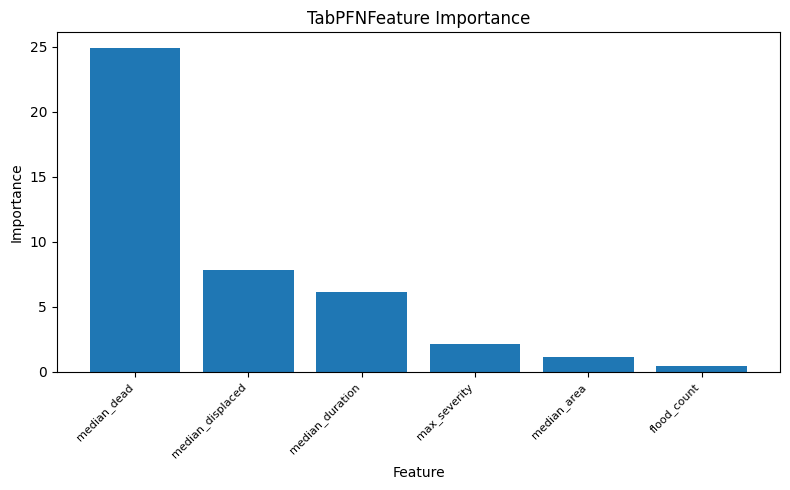

In [70]:
from sklearn.inspection import permutation_importance
scoring_metric = 'neg_mean_absolute_error'
result = permutation_importance(tabpfn_model, X_test, y_test, scoring=scoring_metric, n_repeats=2, random_state=42)

importances = result.importances_mean
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(feature_names[sorted_indices], importances[sorted_indices])
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.title("TabPFNFeature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Residual analysis plot

/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/Users/melinagarza/.local/share/virtualenvs/ml-climate-hKMYu0YM/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:3453: RuntimeWarning: overflow encountered in cast
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


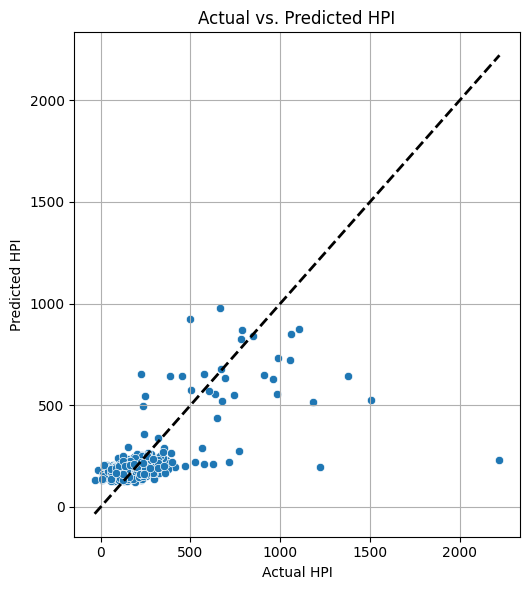

In [71]:
import seaborn as sns
y_pred = tabpfn_model.predict(X_test)

plt.figure(figsize=(10, 6))

# Subplot 1: Scatter plot of Actual vs. Predicted HPI
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.xlabel('Actual HPI')
plt.ylabel('Predicted HPI')
plt.title('Actual vs. Predicted HPI')
plt.grid(True)

plt.tight_layout()
plt.show()

## Cat Booost

### load data

In [72]:
#load best Cat Boost model
#current year, synthetic data
with open('catboost_regressor_synthetic_current_year.pkl', 'rb') as f:
    catboost_model = pickle.load(f)

In [73]:
#load data
expanded_data_catboost = pd.read_csv('expanded_data_catboost.csv', dtype={'zipcode': str})

#split data
X = expanded_data_catboost[['flood_count', 'max_severity', 'median_dead', 'median_displaced', 'median_duration', 'median_area']]
y = expanded_data_catboost['HPI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


### Feature Importance/SHAP Values

Feature Importances:
median_dead: 20.1424
median_displaced: 11.5681
median_duration: 8.4049
median_area: 6.7207
max_severity: 5.6479
flood_count: 2.6377


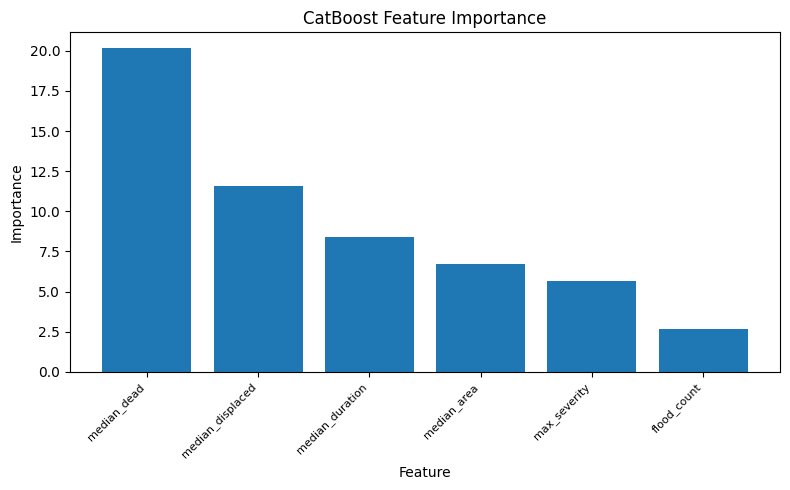

In [74]:
from sklearn.inspection import permutation_importance
scoring_metric = 'neg_mean_absolute_error'
result = permutation_importance(catboost_model, X_test, y_test, scoring=scoring_metric, n_repeats=2, random_state=42)

importances = result.importances_mean
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(feature_names[sorted_indices], importances[sorted_indices])
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.title("CatBoost Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

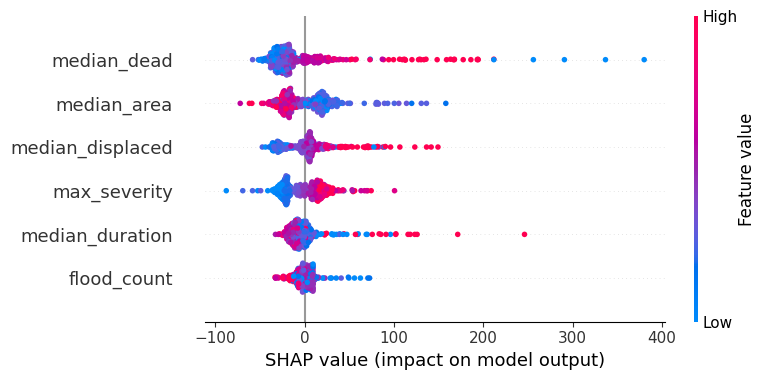

In [76]:
import shap
explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Residual analysis plot

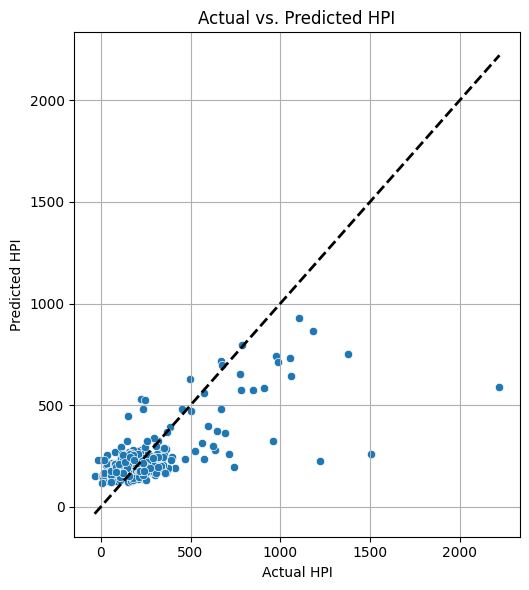

In [ ]:
y_pred = catboost_model.predict(X_test)

plt.figure(figsize=(10, 6))

# Subplot 1: Scatter plot of Actual vs. Predicted HPI
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
plt.xlabel('Actual HPI')
plt.ylabel('Predicted HPI')
plt.title('Actual vs. Predicted HPI')
plt.grid(True)

plt.tight_layout()
plt.show()